# Challenge ML Pento

Hi! My name is Mauro Aguirregaray, and this is my submission for the Pento Machine Learning Challenge.

The challenge involves a dataset with 4 classes of dogs, each consisting of just 20 images. My goal is to create a classifier that can predict these 4 classes and potentially generalize to a new class.

Given the expected time constraint of 4 hours, I plan to start with a basic convolutional model as a reference. I will then enhance the model using data augmentation and transfer learning to see how much performance can be improved.

I expect that the original and data augmentated model with a CNN will poor performances, and with transfer learning will improve.

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

import torch
import torchvision
import torchsummary
import torchmetrics
import torch.nn as nn

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split

## Load the data

First of all we have to load the data:

In [77]:
# Load the image datase
dogs = datasets.ImageFolder(root='dogs')

# View the labels and assigned classes
print(dogs.class_to_idx)  # Shows the classes and their index
print(len(dogs))  # Total number of images

{'french_bulldog': 0, 'german_shepherd': 1, 'golden_retriever': 2, 'poodle': 3}
80


Let's visualize some of the images:

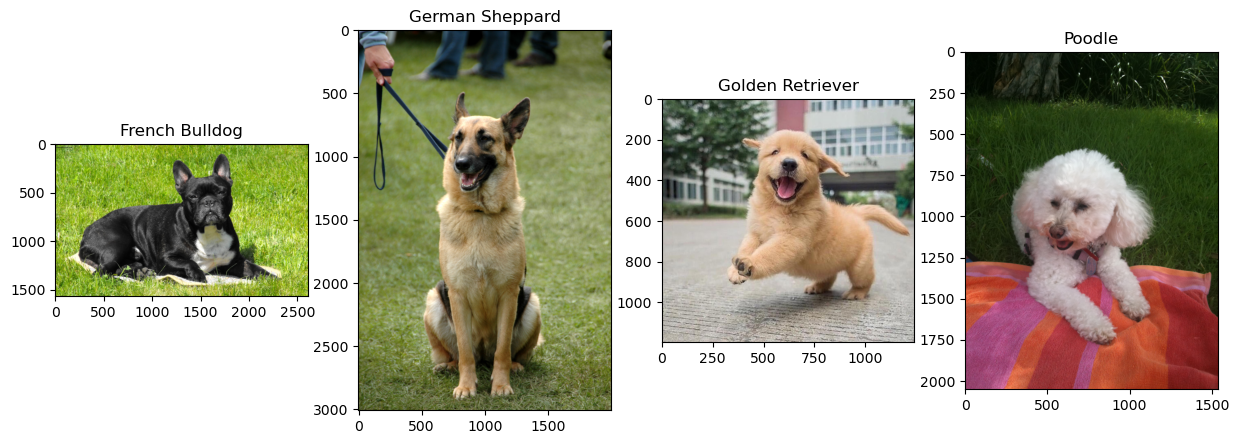

In [78]:
french_bulldog_image_name = random.choice(os.listdir("./dogs/french_bulldog"))
french_bulldog_image = mpimg.imread(os.path.join("./dogs/french_bulldog", french_bulldog_image_name))
german_shepherd_image_name = random.choice(os.listdir("./dogs/german_shepherd"))
german_shepherd_image = mpimg.imread(os.path.join("./dogs/german_shepherd", german_shepherd_image_name))
golden_retriever_image_name = random.choice(os.listdir("./dogs/golden_retriever"))
golden_retriever_image = mpimg.imread(os.path.join("./dogs/golden_retriever", golden_retriever_image_name))
poodle_image_name = random.choice(os.listdir("./dogs/poodle"))
poodle_image = mpimg.imread(os.path.join("./dogs/poodle", poodle_image_name))

# Plot the images
fig, axs = plt.subplots(1, 4, figsize=(15, 10))

axs[0].imshow(french_bulldog_image)
axs[0].title.set_text('French Bulldog')

axs[1].imshow(german_shepherd_image)
axs[1].title.set_text('German Sheppard')

axs[2].imshow(golden_retriever_image)
axs[2].title.set_text('Golden Retriever')

axs[3].imshow(poodle_image)
axs[3].title.set_text('Poodle')

The images are of high resolution and come in different sizes, which means the differences between the dogs are clearly recognizable. However, this also means that we'll need to resize the images.

## Data analysis

As mentioned at the beginning, I propose working with the dataset as it is and incorporating data augmentation. Although the number of images for training will remain limited, we can use this as a reference point for performance evaluation.

In [79]:
# We resize all the images to the same size
image_width = 224
image_height = 224

# Amount of classes
classes = 4

In [80]:
# We build the augmentation data transforms
aug_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.Resize(size=(image_width, image_height)),
                        torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.RandomResizedCrop(size=(image_width, image_height), scale=(0.5, 1.0)),
                        torchvision.transforms.ColorJitter(saturation=0.05, hue=0.05),
                        torchvision.transforms.ToTensor()
                      ])

aug_dogs = datasets.ImageFolder(root='dogs', transform=aug_data_transforms)

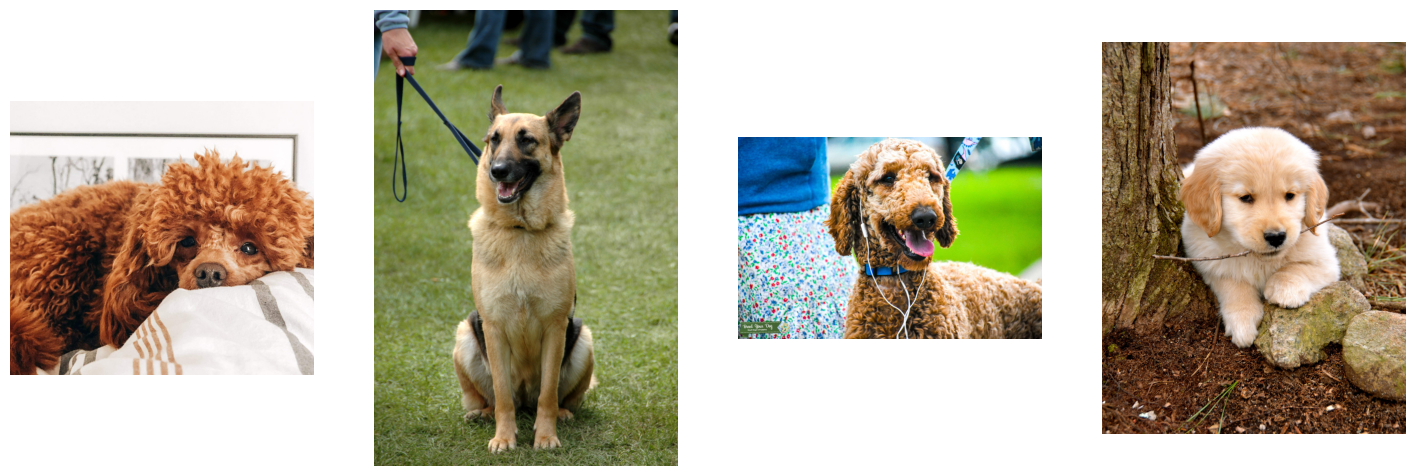

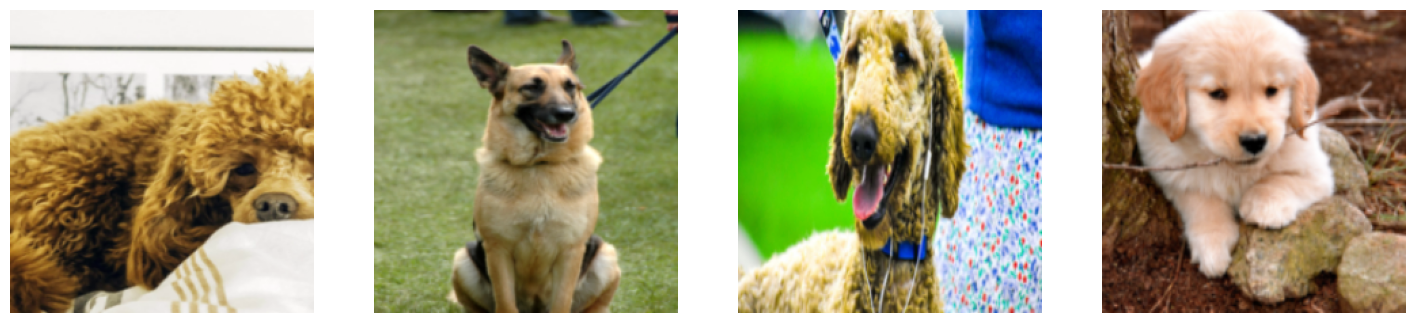

In [81]:
images_ids = np.random.randint(low=0, high=len(dogs), size=4)

# Plotting original images

fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))

for id, row in enumerate(rows):
    row.imshow(dogs[images_ids[id]][0])
    row.axis('off')
plt.show()

# Plotting data augmentation images

fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))

for id, row in enumerate(rows):
    row.imshow(aug_dogs[images_ids[id]][0].permute(1, 2, 0))
    row.axis('off')
plt.show()

Great, we have the data augmentation for the images, the total number of images is still relatively low for an AI model, but now, for each epoch the model will see *new images*.

## Train-Test Split



In [82]:
from torch.utils.data import random_split

# Define the sizes for train and test splits
train_size = int(0.8 * len(dogs))  
valid_size = len(dogs) - train_size

We will have two splits, one with data augmentation and one without it.

In [83]:
## Without data augmentation
# Randomly split the dataset
train_dataset, valid_dataset = random_split(dogs, [train_size, valid_size])

# Create DataLoaders for train and test sets
dogs_train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
dogs_valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)


We need to apply data augmentation just for the train split, for the test split we will just resize the images.

In [84]:
# Resize the images
data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size=(image_width, image_height)),
                    torchvision.transforms.ToTensor()
                  ])

In [85]:
## With data augmentation
# Randomly split the dataset
train_dataset, valid_dataset = random_split(dogs, [train_size, valid_size])

# Apply the transforms
train_dataset.dataset.transform = aug_data_transforms
valid_dataset.dataset.transform = data_transforms

# Create DataLoaders for train and test sets
aug_dogs_train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
aug_dogs_valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

## Building my CNN

For the reference model, I'll be building a Convolutional Neural Network with 4 convolutional layers and 2 fully connected layers. This is a standard model that I've used in my studies.

In [90]:
class ConvModel(torch.nn.Module):
    def __init__(self, output_units):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same')
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(in_features=25088, out_features=512)
        self.fc2 = torch.nn.Linear(in_features=512, out_features=output_units)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = self.pool4(torch.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

conv_model = ConvModel(4)

# Si hay una GPU disponible muevo el modelo allí para aprovechar ese recurso
if torch.cuda.is_available():
    conv_model.to("cuda")

torchsummary.summary(conv_model, (3, image_width, image_height))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
         MaxPool2d-2         [-1, 16, 112, 112]               0
            Conv2d-3         [-1, 32, 112, 112]           4,640
         MaxPool2d-4           [-1, 32, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          18,496
         MaxPool2d-6           [-1, 64, 28, 28]               0
            Conv2d-7          [-1, 128, 28, 28]          73,856
         MaxPool2d-8          [-1, 128, 14, 14]               0
            Linear-9                  [-1, 512]      12,845,568
           Linear-10                    [-1, 4]           2,052
Total params: 12,945,060
Trainable params: 12,945,060
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 14.36
Params size (MB): 49.38
Est

## Train Function

In [87]:
def train(model, optimizer, criterion, metric, data, epochs):

    train_loader = data["train"]
    valid_loader = data["valid"]


    if torch.cuda.is_available():
        model.to("cuda")
        metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data.float())
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data.float())
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += metric(output, valid_target).item()

        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return history

## Training the NN

First as we said earlier we will train the custom CNN with just the original data.

Epoch: 1/10 - Train loss 1.471846 - Train Accuracy 0.234375 - Valid Loss 1.430573 - Valid Accuracy 0.250000
Epoch: 2/10 - Train loss 1.401357 - Train Accuracy 0.296875 - Valid Loss 1.387012 - Valid Accuracy 0.250000
Epoch: 3/10 - Train loss 1.380738 - Train Accuracy 0.328125 - Valid Loss 1.393789 - Valid Accuracy 0.125000
Epoch: 4/10 - Train loss 1.363598 - Train Accuracy 0.359375 - Valid Loss 1.413552 - Valid Accuracy 0.187500
Epoch: 5/10 - Train loss 1.333770 - Train Accuracy 0.375000 - Valid Loss 1.472713 - Valid Accuracy 0.125000
Epoch: 6/10 - Train loss 1.314811 - Train Accuracy 0.250000 - Valid Loss 1.470755 - Valid Accuracy 0.187500
Epoch: 7/10 - Train loss 1.233707 - Train Accuracy 0.437500 - Valid Loss 1.499473 - Valid Accuracy 0.250000
Epoch: 8/10 - Train loss 1.165902 - Train Accuracy 0.437500 - Valid Loss 1.593222 - Valid Accuracy 0.250000
Epoch: 9/10 - Train loss 1.090839 - Train Accuracy 0.562500 - Valid Loss 1.562464 - Valid Accuracy 0.187500
Epoch: 10/10 - Train loss 0.

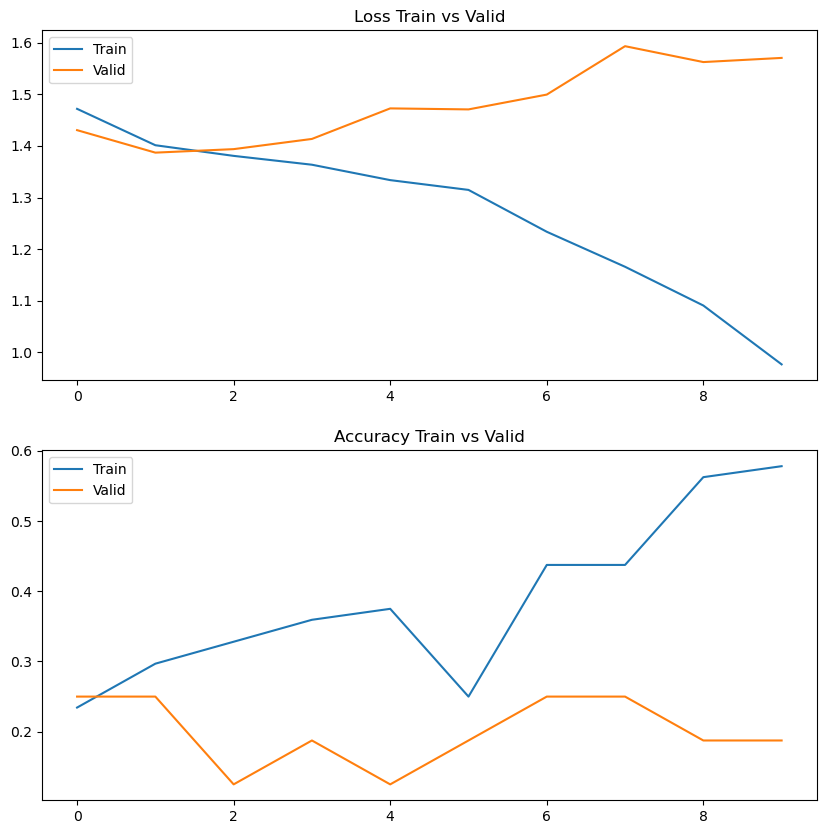

In [91]:
optimizer = torch.optim.Adam(conv_model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy(task='multiclass', num_classes=4)
data = {"train": dogs_train_loader, "valid": dogs_valid_loader, "image_width": image_width, "image_height": image_height}

history = train(conv_model.to("cpu"), 
                optimizer, 
                loss, 
                metric,
                data,
                10,
                )

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"]) 
axs[0].plot(history["valid_loss"]) 
axs[0].title.set_text('Loss Train vs Valid') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(history["train_acc"]) 
axs[1].plot(history["valid_acc"]) 
axs[1].title.set_text('Accuracy Train vs Valid') 
axs[1].legend(['Train', 'Valid'])

As expected the results are pretty bad, the total amount of data is low for a good training so it overfits quickly.

Let's check with the augmentated data.

Epoch: 1/10 - Train loss 1.328182 - Train Accuracy 0.453125 - Valid Loss 1.036961 - Valid Accuracy 0.500000
Epoch: 2/10 - Train loss 0.976823 - Train Accuracy 0.578125 - Valid Loss 1.253484 - Valid Accuracy 0.562500
Epoch: 3/10 - Train loss 1.000155 - Train Accuracy 0.625000 - Valid Loss 1.429970 - Valid Accuracy 0.500000
Epoch: 4/10 - Train loss 0.922493 - Train Accuracy 0.656250 - Valid Loss 1.366540 - Valid Accuracy 0.500000
Epoch: 5/10 - Train loss 0.776518 - Train Accuracy 0.703125 - Valid Loss 1.347137 - Valid Accuracy 0.437500
Epoch: 6/10 - Train loss 0.674106 - Train Accuracy 0.703125 - Valid Loss 1.449137 - Valid Accuracy 0.500000
Epoch: 7/10 - Train loss 0.576927 - Train Accuracy 0.734375 - Valid Loss 1.887369 - Valid Accuracy 0.437500
Epoch: 8/10 - Train loss 0.454686 - Train Accuracy 0.812500 - Valid Loss 1.899370 - Valid Accuracy 0.437500
Epoch: 9/10 - Train loss 0.330203 - Train Accuracy 0.875000 - Valid Loss 2.070352 - Valid Accuracy 0.437500
Epoch: 10/10 - Train loss 0.

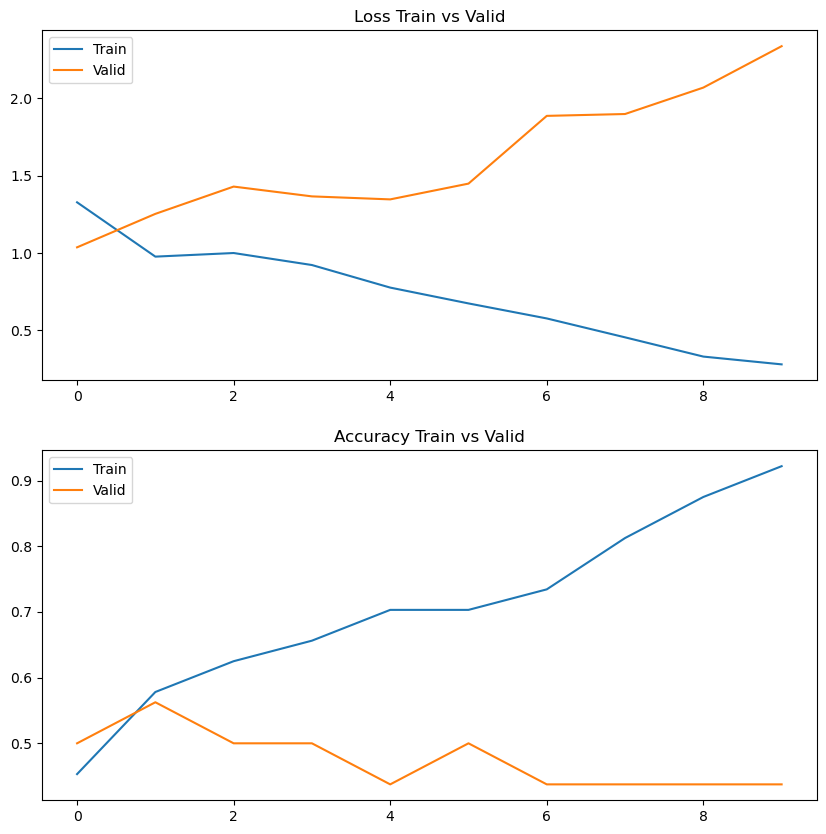

In [93]:
optimizer = torch.optim.Adam(conv_model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy(task='multiclass', num_classes=4)
data = {"train": aug_dogs_train_loader, "valid": aug_dogs_valid_loader, "image_width": image_width, "image_height": image_height}

history = train(conv_model.to("cpu"), 
                optimizer, 
                loss, 
                metric,
                data,
                10,
                )

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"]) 
axs[0].plot(history["valid_loss"]) 
axs[0].title.set_text('Loss Train vs Valid') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(history["train_acc"]) 
axs[1].plot(history["valid_acc"]) 
axs[1].title.set_text('Accuracy Train vs Valid') 
axs[1].legend(['Train', 'Valid'])

Even though there is a better overall performance, in this case it is very clear that within only the 10 epochs that we are training, the model starts to overfit.

As we expected the amount of data is not enough for good performance, let's try now with Transfer Learning

## Transfer Learning

For this particular case, we will be using the pre-trained ResNet50 model. Since this model is much larger than our dataset, the strategy for transfer learning will be feature extraction. We won't retrain the sequential layers of the network, only the final fully connected layer.

In [94]:
from torchvision.models import resnet50, ResNet50_Weights

weights = ResNet50_Weights.IMAGENET1K_V1
transforms = weights.transforms()

In [95]:
resnet50_model = resnet50(weights=weights)

if torch.cuda.is_available():
    resnet50_model.to("cuda")

torchsummary.summary(resnet50_model, input_size=(3, 224, 224))
resnet50_model.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256,

In [99]:
# Freeze all the convolutional layers
for param in resnet50_model.parameters():
    param.requires_grad = False

# Modify the fully connected layer for 4 classes
num_features = resnet50_model.fc.in_features
resnet50_model.fc = nn.Linear(num_features, 4)

# Apply the corresponding data transformations
transforms = weights.transforms()

# Move the resnet50_model to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50_model = resnet50_model.to(device)

In [100]:
torchsummary.summary(resnet50_model, input_size=(3, 224, 224))
resnet50_model.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256,

Epoch: 1/10 - Train loss 1.584486 - Train Accuracy 0.250000 - Valid Loss 1.396325 - Valid Accuracy 0.375000
Epoch: 2/10 - Train loss 1.208991 - Train Accuracy 0.546875 - Valid Loss 0.987380 - Valid Accuracy 0.750000
Epoch: 3/10 - Train loss 0.996647 - Train Accuracy 0.593750 - Valid Loss 0.856131 - Valid Accuracy 0.625000
Epoch: 4/10 - Train loss 0.825966 - Train Accuracy 0.687500 - Valid Loss 0.713474 - Valid Accuracy 0.812500
Epoch: 5/10 - Train loss 0.632939 - Train Accuracy 0.953125 - Valid Loss 0.585285 - Valid Accuracy 0.937500
Epoch: 6/10 - Train loss 0.499359 - Train Accuracy 1.000000 - Valid Loss 0.515583 - Valid Accuracy 1.000000
Epoch: 7/10 - Train loss 0.409605 - Train Accuracy 0.968750 - Valid Loss 0.447424 - Valid Accuracy 1.000000
Epoch: 8/10 - Train loss 0.328679 - Train Accuracy 1.000000 - Valid Loss 0.348633 - Valid Accuracy 1.000000
Epoch: 9/10 - Train loss 0.256076 - Train Accuracy 1.000000 - Valid Loss 0.284122 - Valid Accuracy 1.000000
Epoch: 10/10 - Train loss 0.

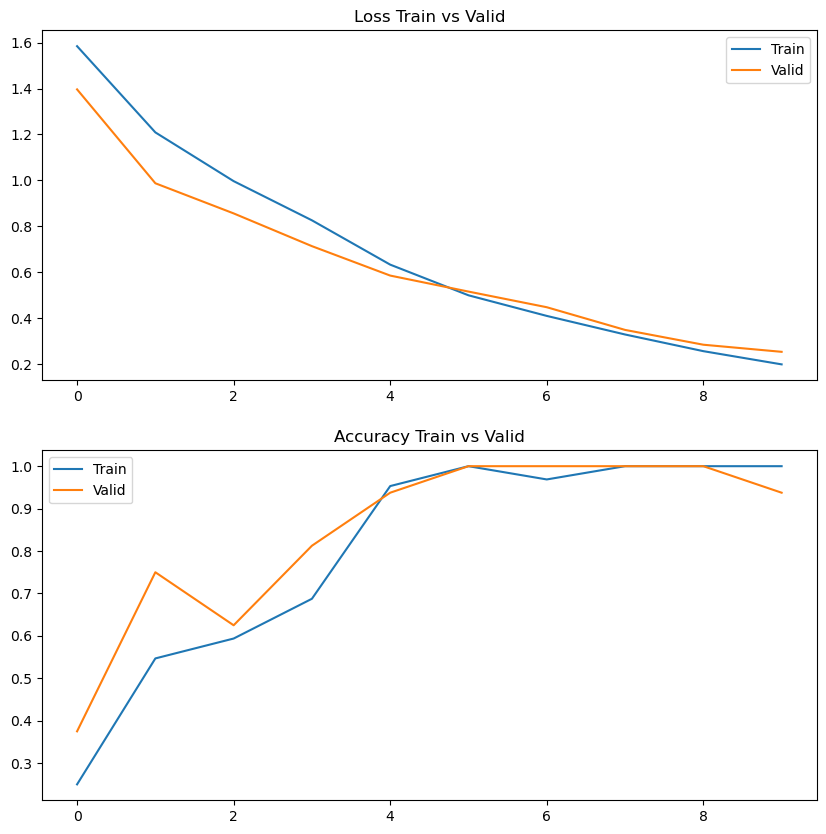

In [101]:
optimizer = torch.optim.Adam(resnet50_model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy(task='multiclass', num_classes=4)
data = {"train": aug_dogs_train_loader, "valid": aug_dogs_valid_loader, "image_width": image_width, "image_height": image_height}

history = train(resnet50_model.to("cpu"), 
                optimizer, 
                loss, 
                metric,
                data,
                10,
                )

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"]) 
axs[0].plot(history["valid_loss"]) 
axs[0].title.set_text('Loss Train vs Valid') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(history["train_acc"]) 
axs[1].plot(history["valid_acc"]) 
axs[1].title.set_text('Accuracy Train vs Valid') 
axs[1].legend(['Train', 'Valid'])

Using transfer learning, the model performs exceptionally well, achieving nearly perfect results. While the small dataset size contributes to reaching an accuracy of 1, the difference in performance between this model and the previous one is still quite significant.

## Using the model



In this final section of the notebook, I will make the model available for inference. Additionally, I will introduce a threshold so that if the model cannot predict the class of an image with a high level of confidence, it will classify the image as 'other'.

In [102]:
# Load your model
model = resnet50_model  
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [103]:
import torch
import matplotlib.image as mpimg
import torchvision.transforms as transforms
from PIL import Image  # Import PIL for image conversion


# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the appropriate device

# Define the image size your model expects
image_width, image_height = 224, 224

# Define the transform for the new image
inference_transform = transforms.Compose([
    transforms.Resize((image_height, image_width)),  # Resize to the same size as during training
    transforms.ToTensor(),  # Convert to tensor
])

# List of class names
class_names = ['french_bulldog', 'german_shepard', 'golden_retriever', 'poodle']


In [104]:
def predict_image(image_path, model, transform, class_names):
    # Load the image using mpimg
    image = mpimg.imread(image_path)

    # Convert the NumPy array to a PIL Image
    image = Image.fromarray((image * 255).astype('uint8'))  # Scale to [0, 255]

    # Apply the transformations (resize, convert to tensor, normalize)
    image = transform(image)

    # Add batch dimension (1, C, H, W)
    image = image.unsqueeze(0)

    # Move the image tensor to the same device as the model
    image = image.to(device)

    # Perform inference
    with torch.no_grad():  
        output = model(image)

    # Apply softmax to get probabilities
    probabilities = torch.softmax(output, dim=1)

    # Get the class index with the highest probability
    _, predicted_class = torch.max(probabilities, 1)

    # Convert the predicted index to class label
    predicted_label = class_names[predicted_class.item()]

    # Get the predicted probability for the predicted class
    predicted_probability = probabilities[0][predicted_class].item() * 100  # Convert to percentage

    return predicted_label, predicted_probability, probabilities[0] * 100  # Return probabilities as percentages


In [113]:
# Example usage with dynamic threshold for 'other'
image_path = 'testing/plane.jpg'  # Replace with your image path
dynamic_threshold = 20.0  # Difference threshold to classify as 'other'

predicted_label, predicted_probability, all_probabilities = predict_image(image_path, model, inference_transform, class_names)

# Calculate difference between highest probability and the second highest
sorted_probabilities, sorted_indices = torch.sort(all_probabilities, descending=True)
confidence_gap = sorted_probabilities[0] - sorted_probabilities[1]

if confidence_gap < dynamic_threshold:
    predicted_label = 'other'  # Classify as 'other' if gap is below threshold
    print(f'Predicted class: {predicted_label}')
    print('All class probabilities:')
    for class_name, prob in zip(class_names, all_probabilities):
        print(f'{class_name}: {prob:.2f}%')
else:
    print(f'Predicted class: {predicted_label} with probability: {predicted_probability:.2f}%')
    print('All class probabilities:')
    for class_name, prob in zip(class_names, all_probabilities):
        print(f'{class_name}: {prob:.2f}%')

Predicted class: other
All class probabilities:
french_bulldog: 38.99%
german_shepard: 27.89%
golden_retriever: 13.92%
poodle: 19.19%
